In [1]:
import glob
import pickle
import os
import awkward as ak
import numpy as np
from coffea import processor
from coffea.nanoevents import NanoAODSchema
from coffea.analysis_tools import PackedSelection
import hist
import warnings 
import matplotlib.pyplot as plt
import json

In [2]:
import warnings
warnings.filterwarnings('ignore','Missing cross')
warnings.filterwarnings('ignore','Duplicate')

In [3]:
with open('/users/cmoore24/Public/hgg/standalone_notebooks/skims/skimmer/triggers.json', 'r') as f:
    file_triggers = json.load(f)

In [4]:
file_triggers

{'2017': ['PFHT1050',
  'AK8PFJet400_TrimMass30',
  'AK8PFHT800_TrimMass50',
  'PFJet500',
  'AK8PFJet500'],
 '2018': ['AK8PFJet400_TrimMass30',
  'AK8PFJet420_TrimMass30',
  'AK8PFHT800_TrimMass50',
  'PFHT1050',
  'PFJet500',
  'AK8PFJet500'],
 '2016': ['PFHT800',
  'PFHT900',
  'AK8PFJet360_TrimMass30',
  'AK8PFHT700_TrimR0p1PT0p03Mass50',
  'PFHT650_WideJetMJJ950DEtaJJ1p5',
  'PFHT650_WideJetMJJ900DEtaJJ1p5',
  'PFJet450']}

In [5]:
def PackedSelection_any(self, *names):
    consider = 0
    for name in names:
        idx = self._names.index(name)
        consider |= 1 << idx
    return (self._data & consider) != 0


class TriggerProcessor(processor.ProcessorABC):
    def __init__(self, year="2017"):
        self._year = year
        self._triggers = file_triggers

        self._mutriggers = {
            "2016": ["IsoMu24", "IsoTkMu24", "Mu50", "TkMu50"],
            "2017": ["IsoMu27", "Mu50", "OldMu100", "TkMu100"],
            "2018": ["IsoMu24", "Mu50", "OldMu100", "TkMu100"],
        }

        self._era_runranges = {
            "Run2016B": (272007, 275376),
            "Run2016C": (275657, 276283),
            "Run2016D": (276315, 276811),
            "Run2016E": (276831, 277420),
            "Run2016F": (277772, 278808),
            "Run2016G": (278820, 280385),
            "Run2016H": (280919, 284044),
            "2017A": (294645, 297019),
            "2017B": (297020, 299329),
            "2017C": (299337, 302029),
            "2017D": (302030, 303434),
            "2017E": (303435, 304826),
            "2017F": (304911, 306462),
            "Run2018A": (315252, 316995),
            "Run2018B": (316998, 319312),
            "Run2018C": (319313, 320393),
            "Run2018D": (320394, 325273),
            "Run2018E": (325274, 325765),
        }

    def make_hist(self):
        return hist.Hist(
            hist.axis.StrCategory([], name="trigger", label="Trigger name", growth=True),
            hist.axis.StrCategory([], name="dataset", label="Dataset name", growth=True),
            hist.axis.StrCategory([], name="era", label="Run era", growth=True),
            hist.axis.Regular(100, 0, 1000, name="pt", label="Leading jet $p_T$"),
            hist.axis.Regular(30, 0, 300, name="msd", label="Leading jet $m_{SD}$"),
            label="Events",
        )

    def process(self, events):
        dataset = events.metadata["dataset"]
        isRealData = "genWeight" not in events.fields
        if isRealData:
            for name, (runlo, runhi) in self._era_runranges.items():
                # assumes no era will be split across input files
                if events.run[0] >= runlo and events.run[0] <= runhi:
                    era = name
                    break
        else:
            era = "MC"

        h_excl = self.make_hist()
        h_incl = self.make_hist()

        triggers = PackedSelection()
        trigger_names = self._triggers[self._year]
        for tname in trigger_names:
            if tname in events.HLT.fields:
                triggers.add(tname, events.HLT[tname])
            else:
                triggers.add(tname, np.zeros(len(events), dtype=bool))

        muontrigger = np.zeros(len(events), dtype=bool)
        for tname in self._mutriggers[self._year]:
            if tname in events.HLT.fields:
                muontrigger |= ak.to_numpy(events.HLT[tname])

        muons = events.Muon[
            (events.Muon.pt > 25)
            & (abs(events.Muon.eta) < 2.4)
            & (events.Muon.pfRelIso04_all < 0.25)
            & events.Muon.looseId
        ]

        jet = ak.firsts(
            events.FatJet[
                (events.FatJet.pt > 200)
                & (abs(events.FatJet.eta) < 2.5)
                & events.FatJet.isTight
                & ak.all(events.FatJet.metric_table(muons) > 0.8, axis=-1)
            ]
        )

        jet_exists = ~ak.is_none(jet) & muontrigger

        h_excl.fill(
            trigger="none",
            dataset=dataset,
            era=era,
            pt=jet[jet_exists].pt,
            msd=jet[jet_exists].msoftdrop,
        )

        cut = jet_exists & PackedSelection_any(triggers, *set(trigger_names))
        h_incl.fill(
            trigger="all",
            dataset=dataset,
            era=era,
            pt=jet[cut].pt,
            msd=jet[cut].msoftdrop,
        )

        for tname in trigger_names:
            cut = jet_exists & triggers.all(tname)
            h_excl.fill(
                trigger=tname,
                dataset=dataset,
                era=era,
                pt=jet[cut].pt,
                msd=jet[cut].msoftdrop,
            )

            cut = jet_exists & PackedSelection_any(triggers, *(set(trigger_names) - {tname}))
            h_incl.fill(
                trigger=tname,
                dataset=dataset,
                era=era,
                pt=jet[cut].pt,
                msd=jet[cut].msoftdrop,
            )

        out = {
                "nevents": {dataset:len(events)},
                "trigger_exclusive": h_excl,
                "trigger_inclusive": h_incl,
        }

        return out

    def postprocess(self, accumulator):
        return accumulator

# Test one

In [6]:
path = '/cms/cephfs/data/store/user/cmoore24/samples'
#MC
files = {}
for year in os.listdir(path):
    files[year] = {}
    for dataset in os.listdir(f'{path}/{year}'):
        if ('Single' in dataset) or ('Jet' in dataset):
            continue
        if '.root' in os.listdir(f'{path}/{year}/{dataset}')[0]:
            files[year][dataset] = [
                f'{path}/{year}/{dataset}/{i}' for i in os.listdir(f'{path}/{year}/{dataset}')
            ][:]
        else:
            files[year][dataset] = {}
            for subset in os.listdir(f'{path}/{year}/{dataset}'):
                files[year][dataset][subset] = [
                    f'{path}/{year}/{dataset}/{subset}/{i}' for i in os.listdir(f'{path}/{year}/{dataset}/{subset}')
                ][:]

#Data
for year in files:
    if year == '2017':
        files[year]['SingleMuon'] = {}
        for dataset in os.listdir(f'{path}/{year}'):
            if ('SingleMuon' not in dataset):
                continue
            for subset in os.listdir(f'{path}/{year}/{dataset}'):
                if '36' in subset:
                    continue
                if '.root' in os.listdir(f'{path}/{year}/{dataset}/{subset}')[0]:
                    files[year]['SingleMuon'][subset] = [
                        f'{path}/{year}/{dataset}/{subset}/{i}' for i in os.listdir(f'{path}/{year}/{dataset}/{subset}')
                    ][:]
                else:
                    files[year]['SingleMuon'][subset] = {}
                    for subsubset in os.listdir(f'{path}/{year}/{dataset}/{subset}'):
                        if '.root' in os.listdir(f'{path}/{year}/{dataset}/{subset}/{subsubset}')[0]:
                            files[year]['SingleMuon'][subset][subsubset] = [
                                f'{path}/{year}/{dataset}/{subset}/{subsubset}/{i}' for i in os.listdir(f'{path}/{year}/{dataset}/{subset}/{subsubset}')
                            ][:]
                        else:
                            files[year]['SingleMuon'][subset][subsubset] = {}
                            for subsubsubset in os.listdir(f'{path}/{year}/{dataset}/{subset}/{subsubset}'):
                                if '.root' in os.listdir(f'{path}/{year}/{dataset}/{subset}/{subsubset}/{subsubsubset}')[0]:
                                    files[year]['SingleMuon'][subset][subsubset][subsubsubset] = [
                                        f'{path}/{year}/{dataset}/{subset}/{subsubset}/{subsubsubset}/{i}' for i in os.listdir(f'{path}/{year}/{dataset}/{subset}/{subsubset}/{subsubsubset}')
                                    ][:]

In [7]:
from coffea.nanoevents import NanoEventsFactory
import warnings
warnings.filterwarnings("ignore", "Found duplicate branch")

year = "2017"
ds = "ht_qcd"
subset = "1000to1500"
events = NanoEventsFactory.from_root(
    {f'{files[year][ds][subset][1]}':'/Events'},
    # "root://cmsxrootd.fnal.gov//store/data/Run2017C/SingleMuon/NANOAOD/02Apr2020-v1/30000/0CC71187-3386-7D44-AA31-2D979D0D14FF.root",
    metadata={"dataset": ds},
    entry_stop=100000,
).events()
proc = TriggerProcessor(year=year)
out = proc.process(events)
out

{'nevents': {'ht_qcd': 81293},
 'trigger_exclusive': Hist(
   StrCategory(['none', 'PFHT1050', 'AK8PFJet400_TrimMass30', 'AK8PFHT800_TrimMass50', 'PFJet500', 'AK8PFJet500'], growth=True, name='trigger', label='Trigger name'),
   StrCategory(['ht_qcd'], growth=True, name='dataset', label='Dataset name'),
   StrCategory(['MC'], growth=True, name='era', label='Run era'),
   Regular(100, 0, 1000, name='pt', label='Leading jet $p_T$'),
   Regular(30, 0, 300, name='msd', label='Leading jet $m_{SD}$'),
   storage=Double()) # Sum: 3653.0 (3668.0 with flow),
 'trigger_inclusive': Hist(
   StrCategory(['all', 'PFHT1050', 'AK8PFJet400_TrimMass30', 'AK8PFHT800_TrimMass50', 'PFJet500', 'AK8PFJet500'], growth=True, name='trigger', label='Trigger name'),
   StrCategory(['ht_qcd'], growth=True, name='dataset', label='Dataset name'),
   StrCategory(['MC'], growth=True, name='era', label='Run era'),
   Regular(100, 0, 1000, name='pt', label='Leading jet $p_T$'),
   Regular(30, 0, 300, name='msd', label=

# Run on cluster

In [8]:
year = "2017"
proc = TriggerProcessor(year=year)
subset_qcd = {
    f'qcd_{k}': v for k,v in files[year]['ht_qcd'].items()
    # if k == "SingleMuon" or k.startswith("QCD_")
    # if k.startswith("ht_qcd")
}
subset
print("\n".join(sorted(subset_qcd.keys())))

qcd_1000to1500
qcd_100to200
qcd_1500to2000
qcd_2000toInf
qcd_200to300
qcd_300to500
qcd_500to700
qcd_50to100
qcd_700to1000


In [9]:
singlemuons = {}
for i in files[year]['SingleMuon']:
    for j in files[year]['SingleMuon'][i]:
        if type(files[year]['SingleMuon'][i][j]) == dict:
            temp_list = []
            for k in files[year]['SingleMuon'][i][j]:
                temp_list = temp_list + (files[year]['SingleMuon'][i][j][k])
            singlemuons[f'{i}_{j}'] = temp_list
        else:
            singlemuons[f'{i}_{j}'] = files[year]['SingleMuon'][i][j]
subset_sm = {'SingleMuon':[]}
for i in singlemuons:
    subset_sm['SingleMuon'] = subset_sm['SingleMuon'] + singlemuons[i] 
print("\n".join(sorted(subset_sm.keys())))

SingleMuon


In [10]:
subset = subset_qcd | subset_sm

In [11]:
from coffea.processor import (
    TaskVineExecutor,
)
from ndcctools.taskvine import Factory

In [12]:
chunksize = 50_000
maxchunks = None
executor = TaskVineExecutor(
        port=[9101, 9200],
        manager_name=f"{os.environ['USER']}-hgg",
        filepath=f"/scratch365/cmoore24/vine_executor_scratch/",
        environment_file='/scratch365/cmoore24/virtual_jec.tar.gz',
)
runner = processor.Runner(
    executor=executor,
    schema=NanoAODSchema,
    chunksize=chunksize,
    maxchunks=maxchunks,
    skipbadfiles=False,
)

In [13]:
workers = Factory(batch_type="condor", manager_name=f"{os.environ['USER']}-hgg")
workers.min_workers = 1
workers.max_workers = 10
workers.cores = 24
workers.disk = 4096 * 24
workers.memory = 2048 * 24

In [ ]:
with workers:
    out = runner(
        subset,
        processor_instance=proc,
        treename="Events",
    )

GridspecLayout(children=(VBox(children=(HTML(value=''), HTML(value='')), layout=Layout(grid_area='widget001'))…

Output()

Listening for TaskVine workers on port 9101.

In [15]:
import coffea.util
coffea.util.save(out, f"triggerstudy_newmu_{year}.coffea")

In [16]:
out

{'nevents': {'qcd_1000to1500': 14338785,
  'SingleMuon': 946786341,
  'qcd_700to1000': 48847499,
  'qcd_500to700': 49624909,
  'qcd_2000toInf': 5374711,
  'qcd_300to500': 61978583,
  'qcd_1500to2000': 11078198},
 'trigger_exclusive': Hist(
   StrCategory(['none', 'AK8PFJet400_TrimMass30', 'AK8PFJet420_TrimMass30', 'AK8PFHT800_TrimMass50', 'PFHT1050', 'PFJet500', 'AK8PFJet500'], growth=True, name='trigger', label='Trigger name'),
   StrCategory(['qcd_1000to1500', 'SingleMuon', 'qcd_700to1000', 'qcd_500to700', 'qcd_2000toInf', 'qcd_300to500', 'qcd_1500to2000'], growth=True, name='dataset', label='Dataset name'),
   StrCategory(['MC', 'Run2018D', 'Run2018A', 'Run2018C', 'Run2018B'], growth=True, name='era', label='Run era'),
   Regular(100, 0, 1000, name='pt', label='Leading jet $p_T$'),
   Regular(30, 0, 300, name='msd', label='Leading jet $m_{SD}$'),
   storage=Double()) # Sum: 28752005.0 (29766595.0 with flow),
 'trigger_inclusive': Hist(
   StrCategory(['all', 'AK8PFJet400_TrimMass30'

# Analyze original set

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep
import pandas as pd
import coffea.util
# import coffea.hist
import re
from scipy.stats import binomtest
from cycler import cycler

cms10 = [
    "#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6",
    "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd",
]

mplhep.style.use(["CMS", {"axes.prop_cycle": cycler("color", cms10)}])
year = "2018"
out = coffea.util.load(f"triggerstudy_newmu_{year}.coffea")

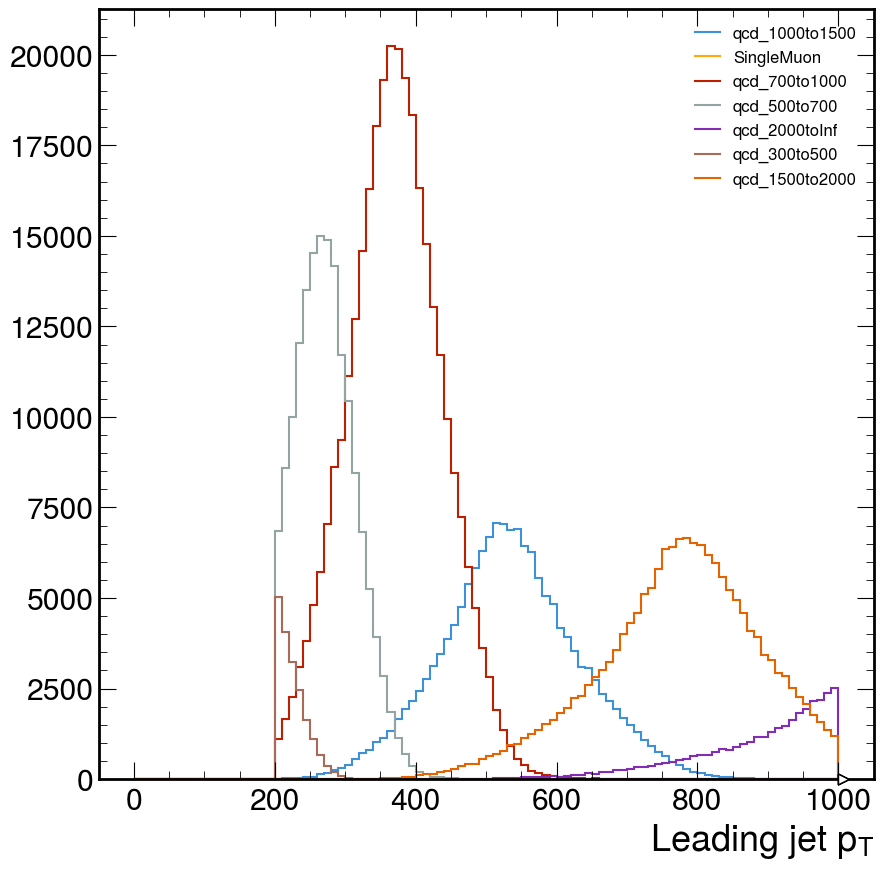

In [18]:
x = (
    out["trigger_exclusive"]['none',:,'MC',:,4:].project('dataset','pt')
    # .integrate("msd")
    # .integrate("era", "MC")
    # # .sum("ddb")
    # .integrate("trigger", "none")
    # # .to_hist()
)
fig, ax = plt.subplots()
for cat in x.axes[0]:
    mplhep.histplot(x[cat, :], ax=ax, label=cat)
ax.legend(fontsize=12)
plt.show()

In [19]:
x = out["trigger_exclusive"].project("trigger", "era")

trig_ax = x.axes["trigger"]
era_ax  = x.axes["era"]

df = pd.DataFrame(
    x.values(),
    index=[trig_ax.value(i) for i in range(trig_ax.size)],
    columns=[era_ax.value(i) for i in range(era_ax.size)],
)

efftable = df / df.loc["none"]

with pd.option_context("display.float_format", "{:.2f}".format):
    # print(efftable.to_latex())
    display(efftable)

,MC,Run2018D,Run2018A,Run2018C,Run2018B
none,1.00,1.00,1.00,1.00,1.00
AK8PFJet400_TrimMass30,0.43,0.05,0.05,0.04,0.05
AK8PFJet420_TrimMass30,0.41,0.04,0.04,0.04,0.04
AK8PFHT800_TrimMass50,0.31,0.02,0.02,0.02,0.02
PFHT1050,0.38,0.02,0.02,0.02,0.02
PFJet500,0.36,0.02,0.02,0.02,0.02
AK8PFJet500,0.39,0.02,0.02,0.02,0.02


In [50]:
df

,MC,Run2018D,Run2018C,Run2018A,Run2018B
none,948850.0,11870741.0,2557793.0,5613409.0,2622994.0
AK8PFJet400_TrimMass30,410891.0,562897.0,114559.0,267636.0,118318.0
AK8PFJet420_TrimMass30,388902.0,471070.0,95540.0,224521.0,98806.0
AK8PFHT800_TrimMass50,296142.0,277563.0,56210.0,133719.0,58414.0
PFHT1050,360986.0,261407.0,52775.0,127395.0,54982.0
PFJet500,345634.0,253307.0,50214.0,122618.0,52130.0
AK8PFJet500,365395.0,281716.0,55887.0,135427.0,57747.0


In [20]:
out['trigger_inclusive'][:,'SingleMuon',1:,:,4:]

Hist(
  StrCategory(['all', 'AK8PFJet400_TrimMass30', 'AK8PFJet420_TrimMass30', 'AK8PFHT800_TrimMass50', 'PFHT1050', 'PFJet500', 'AK8PFJet500'], growth=True, name='trigger', label='Trigger name'),
  StrCategory(['Run2018D', 'Run2018A', 'Run2018C', 'Run2018B'], growth=True, name='era', label='Run era'),
  Regular(100, 0, 1000, name='pt', label='Leading jet $p_T$'),
  Regular(26, 40, 300, name='msd', label='Leading jet $m_{SD}$'),
  storage=Double()) # Sum: 3950155.0 (8454769.0 with flow)

/users/cmoore24/miniconda3/envs/virtual_jec/lib/python3.9/site-packages/hist/basehist.py:480: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/tmp/ipykernel_1737376/4185140701.py:14: RuntimeWarning: invalid value encountered in divide
  ratio = num / den
/tmp/ipykernel_1737376/4185140701.py:37: RuntimeWarning: invalid value encountered in divide
  ratio = num / den


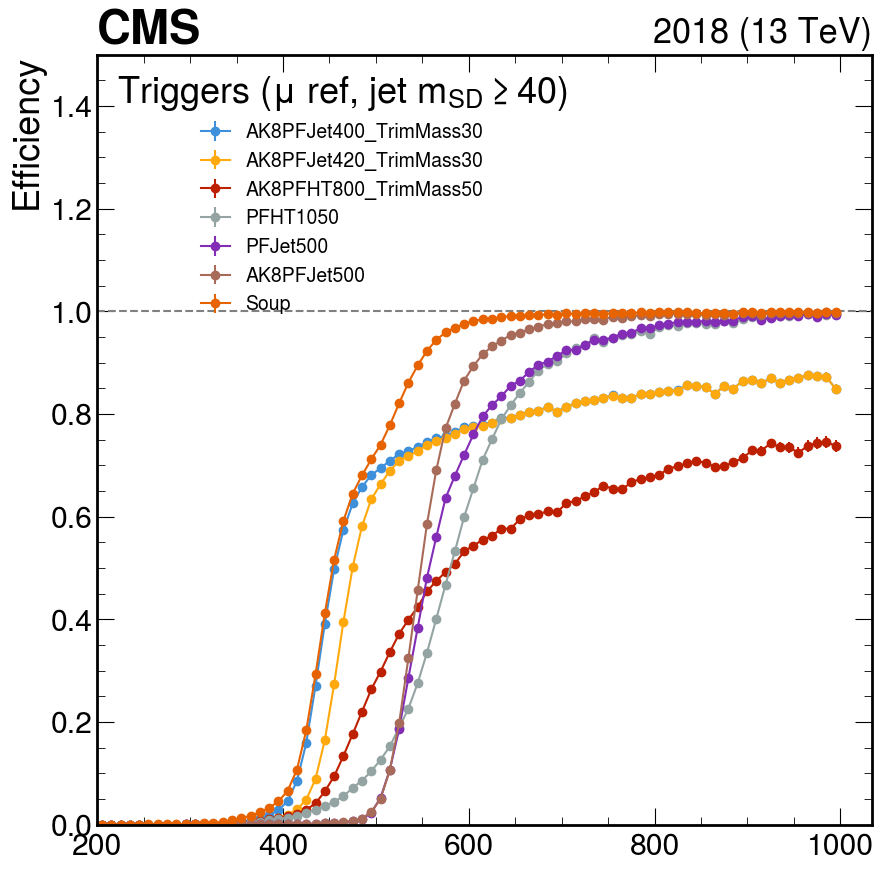

In [21]:
fig, ax = plt.subplots()

ptproj = out['trigger_exclusive'][:,'SingleMuon','Run*',:,4:].project('trigger','pt')

denom = ptproj["none", :]
x = denom.axes["pt"].centers
den = denom.values()

for tname in ptproj.axes["trigger"]:
    if tname == "none":
        continue

    num = ptproj[tname, :].values()
    ratio = num / den

    lo = np.full_like(x, np.nan, dtype=float)
    hi = np.full_like(x, np.nan, dtype=float)
    for i in range(len(den)):
        if den[i] == 0:
            continue
        ci = binomtest(num[i].astype(int), den[i].astype(int)).proportion_ci(confidence_level=0.68, method="exact")
        lo[i], hi[i] = ci.low, ci.high
    unc = np.vstack((ratio - lo, hi - ratio))

    ax.errorbar(
        x,
        ratio,
        yerr=unc,
        fmt="o-",
        # lw=1.5,
        # ms=3,
        label=str(tname),
    )


num = out['trigger_inclusive']['all','SingleMuon','Run*',:,4:].project('pt').values()
ratio = num / den

lo = np.full_like(x, np.nan, dtype=float)
hi = np.full_like(x, np.nan, dtype=float)
for i in range(len(den)):
    if den[i] == 0:
        continue
    ci = binomtest(num[i].astype(int), den[i].astype(int)).proportion_ci(confidence_level=0.68, method="exact")
    lo[i], hi[i] = ci.low, ci.high
unc = np.vstack((ratio - lo, hi - ratio))

ax.errorbar(
    x,
    ratio,
    yerr=unc,
    fmt="o-",
    # lw=1,
    # ms=3,
    label='Soup',
)


ax.set_ylabel("Efficiency")
ax.set_ylim(0, 1.5)
ax.set_xlim(200, None)
ax.axhline(y=1, linestyle="--", color="gray")
ax.legend(title="Triggers ($\mu$ ref, jet $m_{SD}\geq 40$)", fontsize=14)
mplhep.cms.label(ax=ax, data=True, year=year)
fig.savefig(f"exclusive_efficiency_data_pt_{year}.pdf")

In [22]:
out['trigger_exclusive'][:,'qcd*','MC',:,4:]

/users/cmoore24/miniconda3/envs/virtual_jec/lib/python3.9/site-packages/hist/basehist.py:480: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Hist(
  StrCategory(['none', 'AK8PFJet400_TrimMass30', 'AK8PFJet420_TrimMass30', 'AK8PFHT800_TrimMass50', 'PFHT1050', 'PFJet500', 'AK8PFJet500'], growth=True, name='trigger', label='Trigger name'),
  StrCategory(['qcd_1000to1500', 'qcd_700to1000', 'qcd_500to700', 'qcd_2000toInf', 'qcd_300to500', 'qcd_1500to2000'], growth=True, name='dataset', label='Dataset name'),
  Regular(100, 0, 1000, name='pt', label='Leading jet $p_T$'),
  Regular(26, 40, 300, name='msd', label='Leading jet $m_{SD}$'),
  storage=Double()) # Sum: 1113247.0 (3116800.0 with flow)

none
AK8PFJet400_TrimMass30


/tmp/ipykernel_1737376/4080031511.py:15: RuntimeWarning: invalid value encountered in divide
  ratio = num / den


AK8PFJet420_TrimMass30
AK8PFHT800_TrimMass50
PFHT1050
PFJet500
AK8PFJet500


/tmp/ipykernel_1737376/4080031511.py:38: RuntimeWarning: invalid value encountered in divide
  ratio = num / den


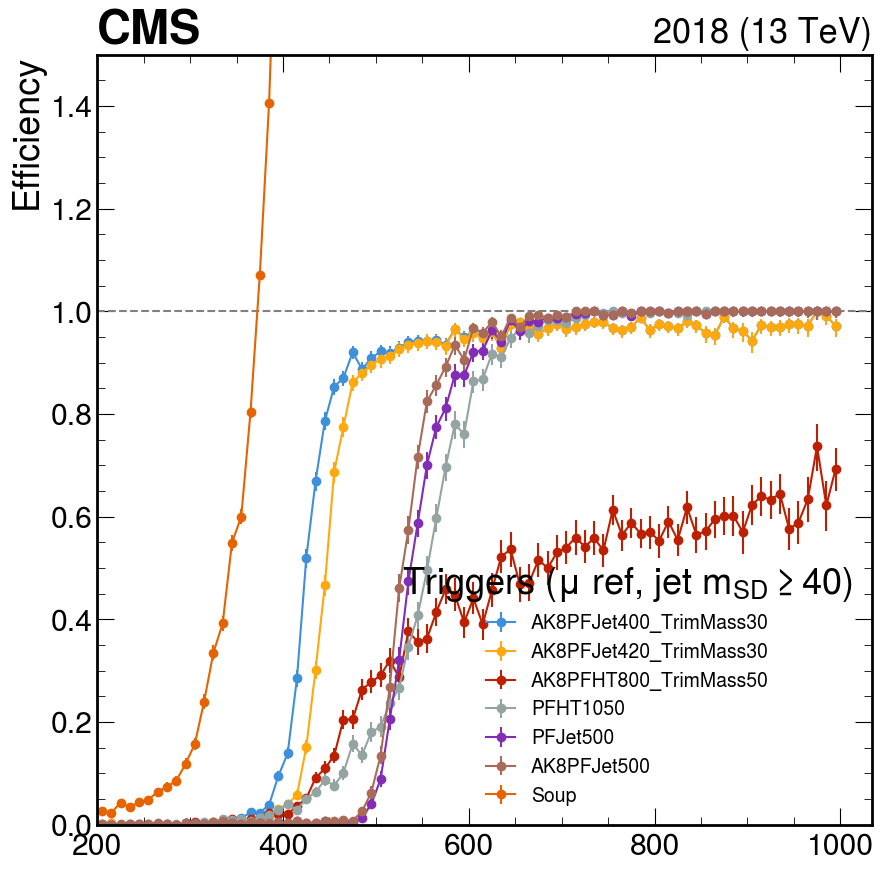

In [23]:
fig, ax = plt.subplots()

ptproj = out['trigger_exclusive'][:,'qcd*','MC',:,4].project('trigger','pt')

denom = ptproj["none", :]
x = denom.axes["pt"].centers
den = denom.values()

for tname in ptproj.axes["trigger"]:
    print(tname)
    if tname == "none":
        continue

    num = ptproj[tname, :].values()
    ratio = num / den

    lo = np.full_like(x, np.nan, dtype=float)
    hi = np.full_like(x, np.nan, dtype=float)
    for i in range(len(den)):
        if den[i] == 0:
            continue
        ci = binomtest(num[i].astype(int), den[i].astype(int)).proportion_ci(confidence_level=0.68, method="exact")
        lo[i], hi[i] = ci.low, ci.high
    unc = np.vstack((ratio - lo, hi - ratio))

    ax.errorbar(
        x,
        ratio,
        yerr=unc,
        fmt="o-",
        # lw=1.5,
        # ms=3,
        label=str(tname),
    )


num = out['trigger_inclusive']['all','qcd*','MC',:,4:].project('pt').values()
ratio = num / den

lo = np.full_like(x, np.nan, dtype=float)
hi = np.full_like(x, np.nan, dtype=float)
for i in range(len(den)):
    if den[i] == 0:
        continue
    try:
        ci = binomtest(num[i].astype(int), den[i].astype(int)).proportion_ci(confidence_level=0.68, method="exact")
        lo[i], hi[i] = ci.low, ci.high
    except:
        lo[i] = np.nan
        hi[i] = np.nan
unc = np.vstack((ratio - lo, hi - ratio))

ax.errorbar(
    x,
    ratio,
    yerr=unc,
    fmt="o-",
    # lw=1,
    # ms=3,
    label='Soup',
)


ax.set_ylabel("Efficiency")
ax.set_ylim(0, 1.5)
ax.set_xlim(200, None)
ax.axhline(y=1, linestyle="--", color="gray")
ax.legend(title="Triggers ($\mu$ ref, jet $m_{SD}\geq 40$)", fontsize=14)
mplhep.cms.label(ax=ax, data=True, year=year)
fig.savefig(f"exclusive_efficiency_data_pt_{year}.pdf")

In [ ]:
fig, ax = plt.subplots()

msdproj = (
    out["trigger_exclusive"]
    .integrate("dataset", "SingleMuon")
    .sum("era", "ddb")
    .integrate("pt", slice(450., None))
)
denom = msdproj.integrate("trigger", "none")
for tname in msdproj.identifiers("trigger"):
    if tname.name == "none":
        continue
    coffea.hist.plotratio(
        num=msdproj.integrate("trigger", tname),
        denom=denom,
        error_opts={'linestyle': '-'},
        label=tname,
        ax=ax,
        clear=False,
    )

coffea.hist.plotratio(
    num=(
        out["trigger_inclusive"]
        .integrate("dataset", "SingleMuon")
        .sum("era", "ddb")
        .integrate("pt", slice(450., None))
        .integrate("trigger", "all")
    ),
    denom=denom,
    error_opts={'linestyle': 'dotted'},
    label="Soup",
    ax=ax,
    clear=False,
)

ax.set_ylabel("Efficiency")
ax.set_ylim(0, 1.5)
ax.axhline(y=1, linestyle="--", color="gray")
ax.legend(title="Triggers ($\mu$ ref, jet $p_T \geq 450$)", fontsize=14)
mplhep.cms.label(ax=ax, data=True, year=year)
fig.savefig(f"exclusive_efficiency_data_msd_{year}.pdf")

In [ ]:
fig, ax = plt.subplots()

msdproj = (
    out["trigger_exclusive"]
    .integrate("dataset", "QCD*")
    .integrate("era", "MC")
    .sum("ddb")
    .integrate("pt", slice(450., None))
)
denom = msdproj.integrate("trigger", "none")
for tname in msdproj.identifiers("trigger"):
    if tname.name == "none":
        continue
    coffea.hist.plotratio(
        num=msdproj.integrate("trigger", tname),
        denom=denom,
        error_opts={'linestyle': '-'},
        label=tname,
        ax=ax,
        clear=False,
    )
    
coffea.hist.plotratio(
    num=(
        out["trigger_inclusive"]
        .integrate("dataset", "QCD*")
        .integrate("era", "MC")
        .sum("ddb")
        .integrate("pt", slice(450., None))
        .integrate("trigger", "all")
    ),
    denom=denom,
    error_opts={'linestyle': 'dotted'},
    label="Soup",
    ax=ax,
    clear=False,
)

ax.set_ylabel("Efficiency")
ax.set_ylim(0, 1.5)
ax.axhline(y=1, linestyle="--", color="gray")
ax.legend(title="Triggers (QCD MC, jet $p_T \geq 450$)", fontsize=14)
mplhep.cms.label(ax=ax, data=True, year=year)
fig.savefig(f"exclusive_efficiency_mc_msd_{year}.pdf")

In [ ]:
from coffea.hist import clopper_pearson_interval
num = (
    out["trigger_inclusive"]
    .integrate("trigger", "all")
    .integrate("dataset")
    .sum("ddb")
    .rebin("pt", 2)
    .rebin("msd", 2)
)
denom = (
    out["trigger_exclusive"]
    .integrate("trigger", "none")
    .integrate("dataset")
    .sum("ddb")
    .rebin("pt", 2)
    .rebin("msd", 2)
)
alldata = re.compile("(Run)?201[678]")
rdata = (
    num.integrate("era", alldata).to_hist().view() 
    / np.maximum(1, denom.integrate("era", alldata).to_hist().view())
)
rdata_unc = clopper_pearson_interval(
    num.integrate("era", alldata).to_hist().view(),
    denom.integrate("era", alldata).to_hist().view(),
)

rmc = (
    num.integrate("era", "MC").to_hist().view()
    / np.maximum(1, denom.integrate("era", "MC").to_hist().view())
)
rmc_unc = clopper_pearson_interval(
    num.integrate("era", "MC").to_hist().view(),
    denom.integrate("era", "MC").to_hist().view(),
)

scalefactor = rdata / np.where(rmc == 0, 1., rmc)
scalefactor_up = rdata_unc[1] / np.where(rmc_unc[0] == 0, np.inf, rmc_unc[0])
scalefactor_dn = rdata_unc[0] / np.where(rmc_unc[1] == 0, 1., rmc_unc[1])
x = num.integrate("era").to_hist()
y = x.copy()
x[...] = (scalefactor_up - scalefactor_dn) / 2 / scalefactor
y[...] = scalefactor

fig, ax = plt.subplots()
artist = mplhep.hist2dplot(y.project(1, 0), ax=ax, cmin=0, cmax=2)
artist.cbar.set_label("Soup efficiency scale factor")
mplhep.cms.label(ax=ax, data=True, year=year)
fig.savefig(f"scalefactor_soup_{year}.pdf")

fig, ax = plt.subplots()
artist = mplhep.hist2dplot(x.project(1, 0), ax=ax, cmin=0, cmax=0.1)
artist.cbar.set_label("Soup efficiency scale factor uncertainty")
mplhep.cms.label(ax=ax, data=True, year=year)
fig.savefig(f"scalefactor_soup_unc_{year}.pdf")

In [ ]:
from correctionlib import schemav2

soup_names = [x.name for x in out["trigger_inclusive"].identifiers("trigger") if x.name != "all"]


def multibinning(sf):
    return schemav2.MultiBinning(
        nodetype="multibinning",
        inputs=["pt", "msd"],
        edges=[list(ax.edges) for ax in x.axes],
        content=list(sf.flatten()),
        flow="clamp",
    )


corr = schemav2.Correction(
    name=f"fatjet_triggerSF{year}",
    description="Year-averaged data-to-simulation correction for trigger soup: " + ",".join(soup_names),
    version=1,
    inputs=[
        schemav2.Variable(
            name="systematic",
            type="string",
            description="Systematic variation",
        ),
        schemav2.Variable(
            name="pt",
            type="real",
            description="Jet transverse momentum (NanoAODv7 nominal value)",
        ),
        schemav2.Variable(
            name="msd",
            type="real",
            description="Jet softdrop mass (NanoAODv7 nominal value)",
        ),
    ],
    output=schemav2.Variable(name="weight", type="real", description="Event weight to correct MC to data"),
    data=schemav2.Category(
        nodetype="category",
        input="systematic",
        content=[
            {"key": "nominal", "value": multibinning(scalefactor)},
            {"key": "stat_up", "value": multibinning(scalefactor_up)},
            {"key": "stat_dn", "value": multibinning(scalefactor_dn)},
        ]
    )
)

cset = schemav2.CorrectionSet(schema_version=2, corrections=[corr])
with open(f"fatjet_triggerSF{year}.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

In [ ]:
from coffea.lookup_tools.dense_lookup import dense_lookup

lookups = {
    year + "_jettrigger": dense_lookup(scalefactor, [ax.edges for ax in x.axes]),
    year + "_jettrigger_up": dense_lookup(scalefactor_up, [ax.edges for ax in x.axes]),
    year + "_jettrigger_down": dense_lookup(scalefactor_dn, [ax.edges for ax in x.axes]),
    year + "_triggers": TriggerProcessor()._triggers[year],
}
coffea.util.save(lookups, f"jettrigger_sf{year}.coffea")

In [ ]:
fig, ax = plt.subplots()

msdproj = (
    out["trigger_exclusive"]
    .integrate("dataset", "QCD*")
    .integrate("era", "MC")
    .integrate("pt", slice(450., None))
    .integrate("msd", slice(40, None))
)
denom = msdproj.integrate("trigger", "none")
for tname in msdproj.identifiers("trigger"):
    if tname.name == "none":
        continue
    coffea.hist.plotratio(
        num=msdproj.integrate("trigger", tname),
        denom=denom,
        error_opts={'linestyle': '-'},
        label=tname,
        ax=ax,
        clear=False,
    )
    
coffea.hist.plotratio(
    num=(
        out["trigger_inclusive"]
        .integrate("dataset", "QCD*")
        .integrate("era", "MC")
        .integrate("pt", slice(450., None))
        .integrate("msd", slice(40, None))
        .integrate("trigger", "all")
    ),
    denom=denom,
    error_opts={'linestyle': 'dotted'},
    label="Soup",
    ax=ax,
    clear=False,
)

ax.set_ylabel("Efficiency")
ax.set_ylim(0.5, 1.5)
ax.axhline(y=1, linestyle="--", color="gray")
ax.legend(title="Triggers (QCD MC, jet $p_T \geq 450$, $m_{SD} \geq 40$)", fontsize=14)
mplhep.cms.label(ax=ax, data=False, year=year)
fig.savefig(f"exclusive_efficiency_mc_ddb_{year}.pdf")

# Other stuff...

In [ ]:
fig, ax = plt.subplots()

ptproj = (
    out["trigger_inclusive"]
    .integrate("dataset")
    .integrate("msd", slice(40, None))
    .integrate("era", "2017*")
)
denom = ptproj.integrate("trigger", "all")
for tname in ptproj.identifiers("trigger"):
    if tname.name == "all":
        continue
    coffea.hist.plotratio(
        num=ptproj.integrate("trigger", tname),
        denom=denom,
        error_opts={'linestyle': '-'},
        label=tname,
        ax=ax,
        clear=False,
    )

ax.set_ylabel("N(soup \ trigger) / N(soup)")
ax.set_ylim(0.8, 1.01)
ax.set_xlim(400, 700)
# ax.axhline(y=1, linestyle="--", color="gray")
ax.legend(title="N-1 efficiency ($\mu$ ref, jet $m_{SD}\geq40$)", fontsize=14)
mplhep.cms.label(ax=ax, data=True, year=2017)
fig.savefig("inclusive_efficiency_data_pt_2017.pdf")

In [ ]:
h = (
    out["trigger_inclusive"]
    .integrate("dataset")
    .integrate("msd", slice(40, None))
    .integrate("era", "2017*")
)[:, 450.:].to_hist()
r = (h.view() / h["all", :].view())
r = np.nan_to_num(r, nan=1.).min(axis=1)
pd.DataFrame({"avg eff": r}, index=h.axes[0]).sort_values("avg eff")

In [ ]:
fig, ax = plt.subplots()

ptproj = (
    out["trigger_inclusive"]
    .integrate("dataset")
    .sum("msd")
    .integrate("era", "MC")
)
denom = ptproj.integrate("trigger", "all")
for tname in ptproj.identifiers("trigger"):
    if tname.name == "all":
        continue
    coffea.hist.plotratio(
        num=ptproj.integrate("trigger", tname),
        denom=denom,
        error_opts={'linestyle': '-'},
        label=tname,
        ax=ax,
        clear=False,
    )

ax.set_ylabel("N(soup \ trigger) / N(soup)")
ax.set_ylim(0.8, 1.01)
ax.set_xlim(400, 700)
# ax.axhline(y=1, linestyle="--", color="gray")
mplhep.cms.label(ax=ax, data=False, year=2017)
ax.legend(title="N-1 efficiency (QCD MC)", fontsize=14)
fig.savefig("inclusive_efficiency_mc_pt_2017.pdf")

In [ ]:
fig, ax = plt.subplots()

msdproj = (
    out["trigger_inclusive"]
    .integrate("dataset")
    .integrate("pt", slice(450, None))
    .integrate("era", "2017*")
)
denom = msdproj.integrate("trigger", "all")
for tname in msdproj.identifiers("trigger"):
    if tname.name == "all":
        continue
    coffea.hist.plotratio(
        num=msdproj.integrate("trigger", tname),
        denom=denom,
        error_opts={'linestyle': '-'},
        label=tname,
        ax=ax,
        clear=False,
    )

ax.set_ylabel("N(soup \ trigger) / N(soup)")
ax.set_ylim(0.9, 1.01)
mplhep.cms.label(ax=ax, data=True, year=2017)
ax.legend(title="N-1 efficiency ($\mu$ ref, jet $p_T \geq 450$)", fontsize=14)
fig.savefig("inclusive_efficiency_data_msd_2017.pdf")

In [ ]:
fig, ax = plt.subplots()

msdproj = (
    out["trigger_inclusive"]
    .integrate("dataset")
    .integrate("pt", slice(450, None))
    .integrate("era", "MC")
)
denom = msdproj.integrate("trigger", "all")
for tname in msdproj.identifiers("trigger"):
    if tname.name == "all":
        continue
    coffea.hist.plotratio(
        num=msdproj.integrate("trigger", tname),
        denom=denom,
        error_opts={'linestyle': '-'},
        label=tname,
        ax=ax,
        clear=False,
    )

ax.set_ylabel("N(soup \ trigger) / N(soup)")
mplhep.cms.label(ax=ax, data=False, year=2017)
ax.legend(title="N-1 efficiency (QCD MC, jet $p_T \geq 450$)", fontsize=14)
fig.savefig("inclusive_efficiency_mc_msd_2017.pdf")

# Scale factors

In [ ]:
out = coffea.util.load("triggerstudy2017.coffea")

In [ ]:
from coffea.lookup_tools.dense_lookup import dense_lookup

lookups = {
    "2017_jettrigger": dense_lookup(scalefactor, [ax.edges for ax in x.axes]),
    "2017_jettrigger_up": dense_lookup(scalefactor_up, [ax.edges for ax in x.axes]),
    "2017_jettrigger_down": dense_lookup(scalefactor_dn, [ax.edges for ax in x.axes]),
    "2017_triggers": TriggerProcessor()._triggers["2017"],
}
coffea.util.save(lookups, "jettrigger_sf.coffea")
lookups

In [ ]:
import uproot

oldsf = uproot.open("https://github.com/nsmith-/coffeandbacon/raw/master/analysis/correction_files/TrigEff_2017BtoF_noPS_Feb21.root")
oldsf = oldsf["h_numer;1"].to_hist() / oldsf["h_denom;1"].to_hist()

In [ ]:
fig, ax = plt.subplots()

artist = mplhep.hist2dplot(oldsf, ax=ax, cmin=0, cmax=2)

In [ ]:
fig, ax = plt.subplots()

artist = mplhep.hist2dplot(rdata.project(1, 0), ax=ax, cmin=0, cmax=2)

In [ ]:
from scipy.interpolate import interp2d

oldsfp = interp2d(*np.meshgrid(oldsf.axes[1].centers, oldsf.axes[0].centers), np.nan_to_num(oldsf.view(), 0))

In [ ]:
oldsfrebin = oldsfp(rdata.axes[0].centers, rdata.axes[1].centers)

fig, ax = plt.subplots()

artist = mplhep.hist2dplot(rdata.project(1, 0) / oldsfrebin, ax=ax, cmin=0, cmax=2)
artist.cbar.set_label("Soup data efficiency / old measurement")
fig.savefig("efficiency_soup_2017_vs_old.pdf")

# Check DDB correlation

In [ ]:
out = coffea.util.load("triggerstudy2017_ddb.coffea")

In [ ]:
num = (
    out["trigger_exclusive"]
    .integrate("dataset")
    .sum("era")
    .integrate("pt", slice(450, None))
    .integrate("msd", slice(40, None))
)
denom = (
    out["trigger_exclusive"]
    .integrate("trigger", "none")
    .integrate("dataset")
    .sum("era")
    .integrate("pt", slice(450, None))
    .integrate("msd", slice(40, None))
)

fig, ax = plt.subplots()

for tname in num.identifiers("trigger"):
    if tname.name == "none":
        continue
    coffea.hist.plotratio(
        num=num.integrate("trigger", tname),
        denom=denom,
        error_opts={'linestyle': '-'},
        label=tname,
        ax=ax,
        clear=False,
    )

ax.set_ylabel("Efficiency")
ax.set_ylim(0, 1.5)
#ax.set_xlim(200, None)
ax.axhline(y=1, linestyle="--", color="gray")
ax.legend(title=r"Triggers (QCD MC, jet $p_T \geq 450$, $m_{SD}\geq 40$)", fontsize=14)
mplhep.cms.label(ax=ax, data=False, year="2017")
fig.savefig("exlusive_efficiency_mc_ddb_2017.pdf")

In [ ]:
fig, ax = plt.subplots()
coffea.hist.plot1d(
    out["trigger_inclusive"]
    .integrate("dataset")
    .sum("era")
    .integrate("pt", slice(450, None))
    .integrate("msd", slice(40, None))
    .integrate("trigger", "all")
)
coffea.hist.plot1d(num.integrate("trigger", "AK8PFJet330_PFAK8BTagCSV_p17"))
ax.set_ylim(1e2, 1e8)
ax.set_yscale("log")